## Demonstration of Zipfs Law in Aesops Fables

### .aesop-fables-runner.js

```javascript
function normalize(string) {
  return string
    .normalize('NFKC')                       // Normalization form, compatibility decomposition followed by canonical composition
    .normalize('NFD')                        // Normalization form, canonical decomposition
    .replace(/(\p{M}|\p{Emoji_Modifier}|\p{P}\p{Sc}\p{Join_Control})/gu, '')  // Remove: marks / diacritics, emoji modifiers, punctuation
    .replace(/(\p{Emoji_Presentation}|\p{Extended_Pictographic})/gu, ' $1 ')  // put spaces around emojis so we treat them as words
    .replace(/\p{White_Space}/gu, ' ')       // transform whitespace to spaces
    .replace(/(\p{Ll})(\p{Lu})/gu, '$1 $2')  // split camelCase
    .replace(/(\p{N})(\p{L})/gu, '$1 $2')    // split number followed by word without space
    .replace(/(\p{L})(\p{N})/gu, '$1 $2')    // split word followed by number without space
    // Replace special characters with spaces
    .replace(/(\.|\|\+|\*|\?|\[|\]|\^|\$|\(|\)|\{|\}|\=|\!|\<|\>|\||\:|\-|\/|,|_|#|`|'|"|~|@|%|&)/g, ' ')
    .replace(/\s+/gu, ' ')                   // remove extra whitespace between
    .toLowerCase();                          // make all text lowercase
}

import fs from 'fs/promises';

(async () => {
    const file = await fs.readFile('../../../public/objects/aesop-fables.json', 'utf8').then(JSON.parse);
    const nf = file.map(story => ({
        title: story.title,
        text: normalize(story.text),
    }));

    await fs.writeFile('.aesop-fables-analysis.json', JSON.stringify(nf, null, 2));
})();
```

In [ ]:
!! node .aesop-fables-runner.js

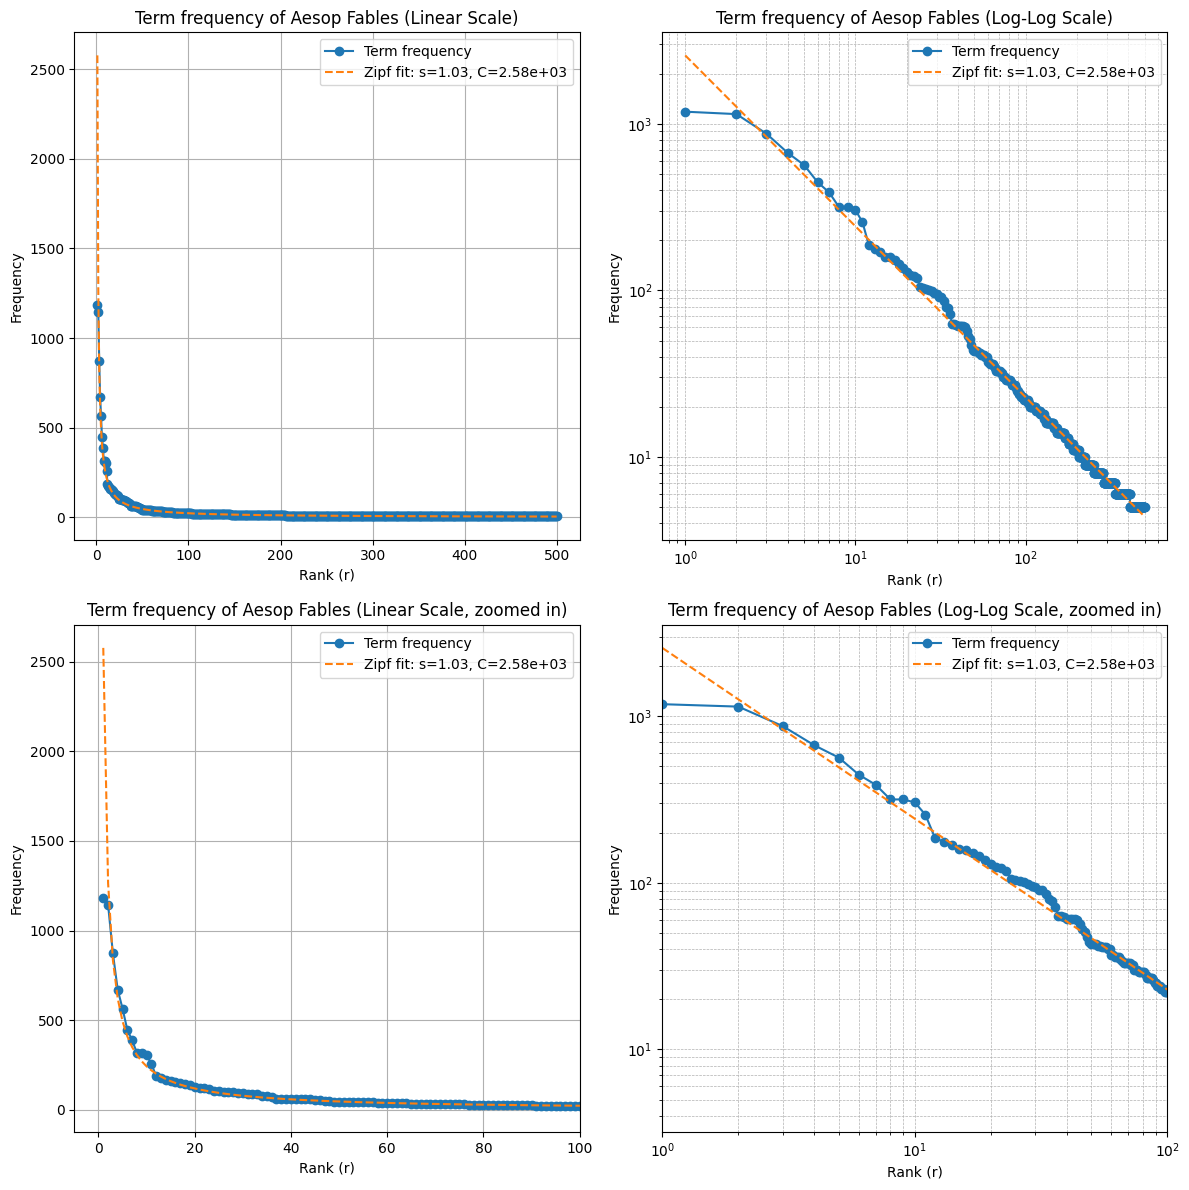

Fitted Zipf parameters: s = 1.026, C = 2.576e+03
R-squared: 0.9952, p-value: 0, std-err: 0.003192


In [2]:
import matplotlib.pyplot as plt
import json
import random
import numpy as np
from scipy.stats import linregress

wordBank = {}

with open('.aesop-fables-analysis.json') as f:
    fables = json.load(f)
    for fable in fables:
        for term in fable['text'].split(' '):
            term = term.strip()
            if not term:
                continue
            wordBank[term] = wordBank.get(term, 0) + 1

n, k = 5, 500

sorted_terms = sorted([(term, count) for term, count in wordBank.items() if count >= n], key=lambda x: x[1], reverse=True)

sampled_terms = random.sample(sorted_terms, min(k, len(sorted_terms)))
sampled_terms.sort(key=lambda x: x[1], reverse=True)

_, frequencies = zip(*sampled_terms)
frequencies = np.array(frequencies)
highFrequencies = frequencies[:len(frequencies) // 2]

# Ranks starting at 1 for proper log
ranks = np.arange(1, len(frequencies) + 1)

# -- Perform Zipfian regression using scipy --
log_ranks = np.log(ranks)
log_freqs = np.log(frequencies)
slope, intercept, r_value, p_value, std_err = linregress(log_ranks, log_freqs)

# We define s = -slope to match the usual Zipf form (f = C * r^-s)
s = -slope
C = np.exp(intercept)

# Compute the fitted Zipf curve
zipf_fit = C / (ranks ** s)

# Create figure with two subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Linear scale plot
axs[0][0].plot(ranks, frequencies, marker='o', linestyle='-', label="Term frequency")
axs[0][0].plot(ranks, zipf_fit, '--', label=f"Zipf fit: s={s:.2f}, C={C:.2e}")
axs[0][0].set_xlabel('Rank (r)')
axs[0][0].set_ylabel('Frequency')
axs[0][0].set_title("Term frequency of Aesop Fables (Linear Scale)")
axs[0][0].grid(True)
axs[0][0].legend()

# Log-log scale plot
axs[0][1].plot(ranks, frequencies, marker='o', linestyle='-', label="Term frequency")
axs[0][1].plot(ranks, zipf_fit, '--', label=f"Zipf fit: s={s:.2f}, C={C:.2e}")
axs[0][1].set_xlabel('Rank (r)')
axs[0][1].set_ylabel('Frequency')
axs[0][1].set_title("Term frequency of Aesop Fables (Log-Log Scale)")
axs[0][1].set_xscale('log')
axs[0][1].set_yscale('log')
axs[0][1].grid(True, which="both", linestyle="--", linewidth=0.5)
axs[0][1].legend()

# Linear scale plot
axs[1][0].plot(ranks, frequencies, marker='o', linestyle='-', label="Term frequency")
axs[1][0].plot(ranks, zipf_fit, '--', label=f"Zipf fit: s={s:.2f}, C={C:.2e}")
axs[1][0].set_xlabel('Rank (r)')
axs[1][0].set_ylabel('Frequency')
axs[1][0].set_title("Term frequency of Aesop Fables (Linear Scale, zoomed in)")
axs[1][0].grid(True)
axs[1][0].legend()
axs[1][0].set_xlim([-5, len(ranks) // 5]) 

# Log-log scale plot
axs[1][1].plot(ranks, frequencies, marker='o', linestyle='-', label="Term frequency")
axs[1][1].plot(ranks, zipf_fit, '--', label=f"Zipf fit: s={s:.2f}, C={C:.2e}")
axs[1][1].set_xlabel('Rank (r)')
axs[1][1].set_ylabel('Frequency')
axs[1][1].set_title("Term frequency of Aesop Fables (Log-Log Scale, zoomed in)")
axs[1][1].set_xscale('log')
axs[1][1].set_yscale('log')
axs[1][1].grid(True, which="both", linestyle="--", linewidth=0.5)
axs[1][1].legend()
axs[1][1].set_xlim([1, len(ranks) // 5]) 

plt.tight_layout()
plt.show()

print(f"Fitted Zipf parameters: s = {s:.3f}, C = {C:.3e}")
print(f"R-squared: {r_value**2:.4f}, p-value: {p_value:.4g}, std-err: {std_err:.4g}")

## Sources

- [Wikipedia: Zipf's Law]()
- [Wikipedia: TF-IDF]()
- [KMW: Understanding TF-IDF and BM-25](https://kmwllc.com/index.php/2020/03/20/understanding-tf-idf-and-bm-25/)
